In [1]:
# Automatically reload files when they are changed so there is no need to restart the kernel.
%load_ext autoreload
%autoreload 2

import random

seed = 2023
def reset_seed():
	torch.manual_seed(seed)
	random.seed(seed)
	np.random.seed(seed)

def cuda_get_device():
	is_cuda = torch.cuda.is_available()
	if is_cuda:
		return torch.device("cuda")
	else:
		print("GPU not available, CPU used")
		return torch.device("cpu")

In [2]:
import torch
from torch import nn
import numpy as np
import random

torch.backends.cudnn.deterministic = True

reset_seed()

class GRUWithConvLayer(nn.Module):
	def __init__(self, input_size, output_size, hidden_dim, conv_dropout, fc_dropout, second_layer=False):
		super(GRUWithConvLayer, self).__init__()
		self.hidden_dim = hidden_dim
		kernel_size = 5
		padding = 0
		self.convlayer = nn.Conv2d(1, 1, (kernel_size, kernel_size), stride=1, padding=padding)
		self.batchnorm = nn.BatchNorm2d(1)
		self.conv_dropout = nn.Dropout(p=conv_dropout)
		self.gru = nn.GRU(input_size=input_size - (kernel_size - 1) + 2*padding, hidden_size=hidden_dim, batch_first=True)
		self.fc_dropout = nn.Dropout(p=fc_dropout)
		self.second_layer = second_layer
		if second_layer:
			intermediate_dim = 100
			self.fc1= nn.Linear(hidden_dim, intermediate_dim)
			self.fc2 = nn.Linear(intermediate_dim, output_size)
		else:
			self.fc1 = nn.Linear(hidden_dim, output_size)
	
	def forward(self, x):
		after_conv = self.batchnorm(self.convlayer(x)).squeeze(1)
		after_conv_drop = self.conv_dropout(after_conv)
		hidden = self.gru(after_conv_drop)[0]
		if self.second_layer:
			out = self.fc1(hidden)
			out = self.fc_dropout(out)
			out = self.fc2(out)
		else:
			out = self.fc1(hidden)
		return out

In [3]:
%matplotlib widget

# Load and preprocess data
import torch
from torch import nn
import numpy as np
import pickle

from prep_data import get_all_outdoor_data_batched, preprocess_data_batched
# from prep_data import get_all_data_joint_normalized, get_batches

reset_seed()

# scenario_num = 17
pred_length = 1
seq_length = 16
train_ratio = 0.9
batch_size = 100
augment = False
remove_center = False

# train_data, test_data, train_len, test_len = get_all_outdoor_data_batched(pred_length, seq_length, train_ratio, batch_size, augment=augment, remove_center=remove_center)

# For loading data from a directory
# The naming convention is "all_{seq_length}_{batch_size}_{remove_center}"'
data_file = "Preprocessed Data\\Prediction Length {}\\all_{}_{}_{}.p".format(pred_length, seq_length, batch_size, remove_center)
try: 
	open(data_file, "rb")
	train_data, test_data, train_len, test_len = pickle.load(open(data_file, "rb"))
except FileNotFoundError: # If the data for these particular settings has not been saved to a file yet, create the dataset and save it to a file
	train_data, test_data, train_len, test_len = get_all_outdoor_data_batched(pred_length, seq_length, train_ratio, batch_size, augment=augment, remove_center=remove_center)
	pickle.dump((train_data, test_data, train_len, test_len), open(data_file, "wb+"))

print(train_len)
print(test_len)

5510
620


In [4]:
reset_seed()
device = cuda_get_device()

# Model Hyperparameters
hidden_state_size = 20
conv_dropout = 0.2
fc_dropout = 0.4
second_layer = True
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2]).to(device))
# criterion = nn.BCEWithLogitsLoss()
n_epochs = 3500
lr = 0.03
gamma = 0.6
milestones =  [100, 200, 400, 1000, 2000, 2500]

if remove_center:
	input_size = 54
else:
	input_size = 64

model = GRUWithConvLayer(input_size=input_size, output_size=1, hidden_dim=hidden_state_size, conv_dropout=conv_dropout, fc_dropout=fc_dropout, second_layer=second_layer)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# Training Run
loss_sequence = []
for epoch in range(1, n_epochs + 1):
	epoch_losses = torch.tensor([0],dtype=float).to(device)
	# Avoid shuffling the original train_data to ensure reproducibility
	shuffled_train_data = train_data
	# random.shuffle(shuffled_train_data) # This does not work
	for data in shuffled_train_data:
		optimizer.zero_grad()
		# Need to include an additional dimensions of size 1 for the number of channels
		input_data = data[0].unsqueeze(1).float().to(device)
		target_pred = data[1].unsqueeze(1).float().to(device)
		output = model(input_data)[:,-1,:]
		loss = criterion(output, target_pred)
		loss.backward()
		optimizer.step()
		epoch_losses += loss
	scheduler.step()
	avg_epoch_loss = epoch_losses.to('cpu').item()/len(train_data)
	loss_sequence.append(avg_epoch_loss)
	if epoch%5 == 0:
		print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
		print("Loss: {:.4f}".format(avg_epoch_loss))

Epoch: 5/3500............. Loss: 0.3604
Epoch: 10/3500............. Loss: 0.3112
Epoch: 15/3500............. Loss: 0.2828
Epoch: 20/3500............. Loss: 0.3014
Epoch: 25/3500............. Loss: 0.2689
Epoch: 30/3500............. Loss: 0.2775
Epoch: 35/3500............. Loss: 0.3048
Epoch: 40/3500............. Loss: 0.3318
Epoch: 45/3500............. Loss: 0.4256
Epoch: 50/3500............. Loss: 0.3405
Epoch: 55/3500............. Loss: 0.3267
Epoch: 60/3500............. Loss: 0.3238
Epoch: 65/3500............. Loss: 0.3112
Epoch: 70/3500............. Loss: 0.3414
Epoch: 75/3500............. Loss: 0.2718
Epoch: 80/3500............. Loss: 0.3169
Epoch: 85/3500............. Loss: 0.3501
Epoch: 90/3500............. Loss: 0.2811
Epoch: 95/3500............. Loss: 0.8060
Epoch: 100/3500............. Loss: 0.4820
Epoch: 105/3500............. Loss: 0.5482
Epoch: 110/3500............. Loss: 0.5717
Epoch: 115/3500............. Loss: 0.4883
Epoch: 120/3500............. Loss: 0.4483
Epoch: 125/3

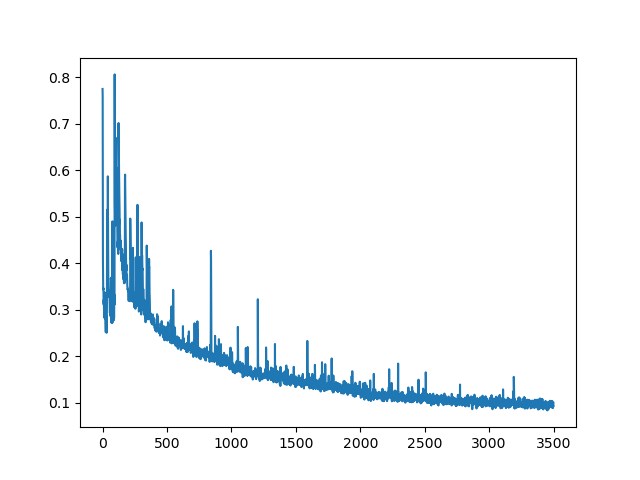

In [5]:
import matplotlib.pyplot as plt
plt.close('all')
plt.figure()
plt.plot(loss_sequence)
plt.show()

In [6]:
reset_seed()
model.eval()

num_blocks_missed = 0
num_false_positives = 0
with torch.no_grad():
	for data in train_data:
		input_data = data[0].unsqueeze(1).float().to(device)
		target_pred = data[1].unsqueeze(1)
		output = torch.round(torch.sigmoid(model(input_data)[:,-1,:])).cpu()
		err = (output - target_pred).numpy()
		num_blocks_missed += np.sum(err < 0)
		num_false_positives += np.sum(err > 0)
	
print("Number of blocks missed: {}".format(num_blocks_missed))
print("Number of false positives: {}".format(num_false_positives))
print("Error rate: {}".format((num_blocks_missed + num_false_positives)/train_len))

Number of blocks missed: 39
Number of false positives: 24
Error rate: 0.011433756805807622


In [7]:
reset_seed()
model.eval()

num_blocks_missed = 0
num_false_positives = 0
with torch.no_grad():
	for data in test_data:
		input_data = data[0].unsqueeze(1).float().to(device)
		target_pred = data[1].unsqueeze(1)
		output = torch.round(torch.sigmoid(model(input_data)[:,-1,:])).cpu()
		err = (output - target_pred).numpy()
		num_blocks_missed += np.sum(err < 0)
		num_false_positives += np.sum(err > 0)
	
print("Number of blocks missed: {}".format(num_blocks_missed))
print("Number of false positives: {}".format(num_false_positives))
print("Error rate: {}".format((num_blocks_missed + num_false_positives)/test_len))

Number of blocks missed: 22
Number of false positives: 25
Error rate: 0.07580645161290323


In [8]:
from prep_data import preprocess_data_batched

scen_17_train, scen_17_test, _, _ = preprocess_data_batched(17, pred_length, seq_length, train_ratio, batch_size=1, augment=augment, remove_center=remove_center, joint_normalize=True)
scen_18_train, scen_18_test, _, _ = preprocess_data_batched(18, pred_length, seq_length, train_ratio, batch_size=1, augment=augment, remove_center=remove_center, joint_normalize=True)
scen_19_train, scen_19_test, _, _ = preprocess_data_batched(19, pred_length, seq_length, train_ratio, batch_size=1, augment=augment, remove_center=remove_center, joint_normalize=True)
scen_20_train, scen_20_test, _, _ = preprocess_data_batched(20, pred_length, seq_length, train_ratio, batch_size=1, augment=augment, remove_center=remove_center, joint_normalize=True)
scen_21_train, scen_21_test, _, _ = preprocess_data_batched(21, pred_length, seq_length, train_ratio, batch_size=1, augment=augment, remove_center=remove_center, joint_normalize=True)

scen_test = [scen_17_test, scen_18_test, scen_19_test, scen_20_test, scen_21_test]

model.eval()

for scen_indx in range(5):
	num_blocks_missed = 0
	num_false_positives = 0
	with torch.no_grad():
		for data in scen_test[scen_indx]:
			input_data = data[0].unsqueeze(1).float().to(device)
			target_pred = data[1].unsqueeze(1)
			output = torch.round(torch.sigmoid(model(input_data)[:,-1,:])).cpu()
			err = (output - target_pred).numpy()
			num_blocks_missed += np.sum(err < 0)
			num_false_positives += np.sum(err > 0)
	print("Scenario {}".format(scen_indx + 17))
	print("Number of blocks missed: {}".format(num_blocks_missed))
	print("Number of false positives: {}".format(num_false_positives))
	print("Error rate: {}".format((num_blocks_missed + num_false_positives)/len(scen_test[scen_indx])))
	print("====================================")

Scenario 17
Number of blocks missed: 2
Number of false positives: 4
Error rate: 0.09090909090909091
Scenario 18
Number of blocks missed: 3
Number of false positives: 1
Error rate: 0.028985507246376812
Scenario 19
Number of blocks missed: 8
Number of false positives: 9
Error rate: 0.07391304347826087
Scenario 20
Number of blocks missed: 5
Number of false positives: 5
Error rate: 0.07462686567164178
Scenario 21
Number of blocks missed: 4
Number of false positives: 6
Error rate: 0.19230769230769232


In [9]:
torch.save(model.state_dict(),"C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\saved_parameters\\all_data_pred_10.model")